In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.datasets import cifar10
import numpy as np

In [2]:
# Load and preprocess CIFAR-10 dataset
(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
input_shape = x_train.shape[1:]



In [3]:
# Latent space dimension
latent_dim = 128

In [4]:
# Encoder
inputs = Input(shape=input_shape)
x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)


In [5]:
# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])


In [6]:
# Decoder
decoder_inputs = Input(shape=(latent_dim,))
x = Dense(8 * 8 * 64, activation='relu')(decoder_inputs)
x = Reshape((8, 8, 64))(x)
x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
outputs = Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)

encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")
decoder = Model(decoder_inputs, outputs, name="decoder")

In [16]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)

        # Compute Reconstruction Loss
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(tf.square(inputs - reconstructed), axis=[1, 2, 3])
        )
        
        # Compute KL Divergence Loss
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        )

        # Add the combined loss to the model
        self.add_loss(reconstruction_loss + kl_loss)
        return reconstructed

# Create and compile the VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')

# Train the VAE
vae.fit(x_train, x_train, epochs=50, batch_size=128, validation_data=(x_test, x_test))


Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 35s 82ms/step - loss: 155.1546 - val_loss: 109.5316
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 75ms/step - loss: 103.3921 - val_loss: 90.5880
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - loss: 88.8110 - val_loss: 84.7727
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - loss: 84.2454 - val_loss: 82.6112
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - loss: 81.8800 - val_loss: 80.7510
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - loss: 80.3228 - val_loss: 80.1203
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 92ms/step - loss: 79.5287 - val_loss: 79.2235
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 35s 88ms/step - loss: 78.8260 - val_loss: 78.7457
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 86ms/step - loss: 78.3230 - val_loss: 78.3434
Epoch 10/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - loss: 78.0161 - val_loss: 78.0544
Epoch 11/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - loss: 77.7440 - val_loss: 77.4771
Epoch

In [19]:
# Visualize results
import matplotlib.pyplot as plt

def plot_reconstruction(model, data):
    num_images = 10
    sampled_images = data[:num_images]
    reconstructed = model.predict(sampled_images)
    
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Original images
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(sampled_images[i])
        plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


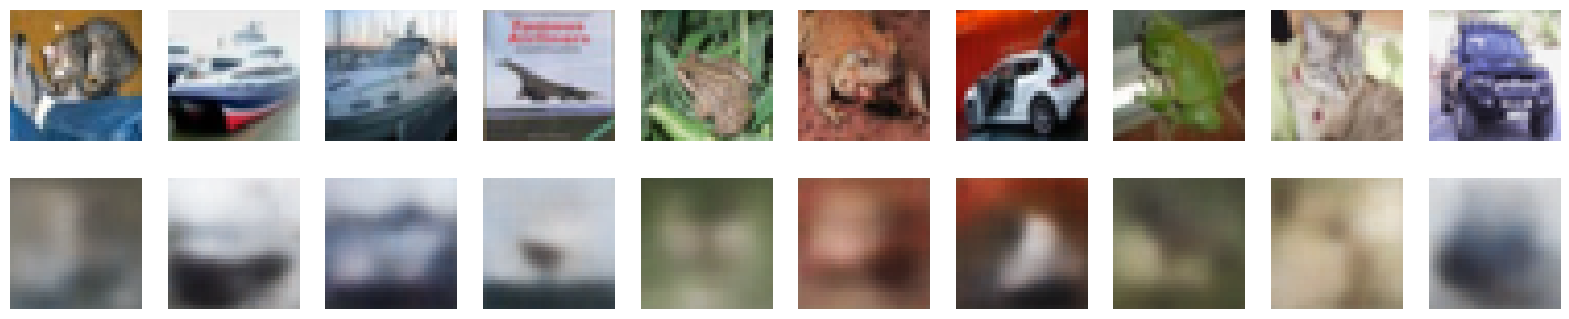

In [23]:
import matplotlib.pyplot as plt

# Define the number of images to display
num_images = 10

# Get reconstructed images from the model
reconstructed = vae.predict(x_test[:num_images])

# Plot original and reconstructed images
plt.figure(figsize=(2 * num_images, 4))
for i in range(num_images):
    # Display original
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(x_test[i])
    plt.axis("off")

    # Display reconstructed
    ax = plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(reconstructed[i])
    plt.axis("off")

plt.show()
